In [8]:
import numpy as np
import time
from numpy.random import rand,randn

import jax
from jax import grad, value_and_grad,random, jit, jacfwd
import jax.numpy as jnp
from jax.ops import index, index_add, index_update

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

from importlib import reload

import jax_nn_utils as jnn
from damped_spring_noise import dampedSpringNoiseJit
import pendulum_utils as PU
reload(PU)
reload(jnn)


<module 'jax_nn_utils' from '/home/bc/projects/deep_rl/jax/jax_nn_utils.py'>

In [9]:
# @jit
# def relu(x):
#     return jnp.maximum(0, x)

# @jit
# def predict_scalar(params, x):
#     # per-example predictions
#     for w, b in params[:-1]:
#         x = relu(w @ x + b)
#     w, b = params[-1]
#     return jnp.squeeze(jnp.dot(w, x) + b)

# predict_scalar(model, np.random.randn(2,1))
# # predict(model, S)

# # np.random.randn(2,10)
# # grad(predict_scalar)(model, np.random.randn(2,1))
# # map_grad = jax.vmap(grad(predict_scalar),(None,1))
# # map_grad(model, np.random.randn(2,1))
# def TD0_grad_step(V_params, R, S, S_next, discount, LR):
#     grads = grad(predict_scalar)(V_params, S)
#     TDerr = LR * (R + discount * predict_scalar(V_params, S_next) - predict_scalar(V_params, S))
#     return [
#         (w - TDerr * dw, b - TDerr * db) for (w, b), (dw, db) in zip(V_params, grads)
#     ]

# R, S, S_next = np.random.randn(1,1), np.random.randn(2,1), np.random.randn(2,1) 
# print(model)
# model = TD0_grad_step(model, R, S, S_next, discount=.99, LR=.1)
# print(model)

In [10]:
# @jit
# def scan_step(pos, step)

# @jit
# def test_scan(th0, thdot0, uVect, params):
#     state = (th0, thdot0, params)
#     _, traj = jax.lax.scan(controlledPendulumStep_scan, state, uVect)
#     return traj


In [11]:
# def TD0_loss(params, R, S, S_next):
#     return jnp.sum((R + discount * predict(params, S_next) - predict(params, S))**2)


In [12]:
# def TD0_grad_step(carry, data):
#     V_params, discount, LR, batch_size = carry
#     R, S, S_next = data
#     grads = grad(predict_scalar)(V_params, S)
#     TDerr = LR * (R + discount * predict_scalar(V_params, S_next) - predict_scalar(V_params, S))
#     return (
#         [
#             (w - TDerr * dw/batch_size, b - TDerr * db/batch_size)
#             for (w, b), (dw, db) in zip(V_params, grads)
#         ], 
#         discount,
#         LR,
#         batch_size
#     )

# def accumulate_TD0_grads(V_params, R, S, S_next, discount, LR):
#     batch_size = R.shape[0]
#     init = V_params, discount, LR, batch_size
#     data = R, S, S_next
#     (V_params,_,_,_), _ = jax.lax.scan(TD0_grad_step, init, data)
#     return [
#         (w - TDerr * dw, b / batch_size) for (w, b) in V_params
#     ]

# batched_update_value_TD0 = jax.vmap(update_value_TD0,(None,(1),(1),(1),None,None))

# model = jnn.init_network_params_He([2,10,1])
# print(model)
# batched_update_value_TD0
# # print(model)
# S = epoch_memory[:-1,0:2].T
# S_next = epoch_memory[1:,0:2].T
# R = epoch_memory[:-1,2].reshape(1,-1)

# print(S.shape, S_next.shape, R.shape)

# accumulate_TD0_grads(model, R[:,:50], S[:,:50], S_next[:,:50], .99, .0001)
# # update_value_TD0(model,R,S,S_next,.99,.0001)


In [13]:
# def update_value_TD0(V_params, R, S, S_next, discount, LR):
#     print(S)
#     grads = grad(predict_scalar)(V_params, S)
#     TDerr = LR * (R + discount * predict_scalar(V_params, S_next) - predict_scalar(V_params, S))
#     return [
#         (w - TDerr * dw, b - TDerr * db) for (w, b), (dw, db) in zip(V_params, grads)
#     ]

# def accumulate_TD0_grads()

# batched_update_value_TD0 = jax.vmap(update_value_TD0,(None,(1),(1),(1),None,None))

# model = jnn.init_network_params_He([2,10,1])
# print(model)
# batched_update_value_TD0
# # print(model)
# S = epoch_memory[:-1,0:2].T
# S_next = epoch_memory[1:,0:2].T
# R = epoch_memory[:-1,2].reshape(1,-1)

# print(S.shape, S_next.shape, R.shape)

# batched_update_value_TD0(model,R,S,S_next,.99,.0001)
# # update_value_TD0(model,R,S,S_next,.99,.0001)

In [17]:
# pendulumTraj_scan = PU.pendulumTraj_scan
params = PU.default_pendulum_params
# plotTrajInPhaseSpace = PU.plotTrajInPhaseSpace

In [18]:
randKey = lambda: random.PRNGKey(int(100000*np.random.rand(1)))

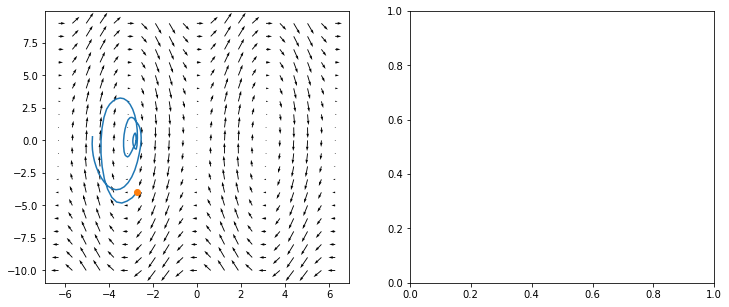

In [20]:
T = 200
traj = PU.pendulumTraj_scan(
    np.pi * (2*rand() - 1),
    8 * (2*rand() - 0.5),
    np.clip(dampedSpringNoiseJit(100,key=randKey()), -params.max_torque, params.max_torque),
    params
)
PU.plotTrajInPhaseSpace(traj, params)


In [21]:
model = jnn.init_network_params_He([2,80,80,1])
# jnn.predict(model,)

# jnn.init_network_params_He

In [51]:
class Plotter2d(object):
    def __init__(self, predict, model, n_grid=100,
    jupyter=True, pend_params=PU.default_pendulum_params):
        self.n_grid = n_grid

        X1, X2 = np.meshgrid(np.pi*np.linspace(-1, 1, n_grid), 8*np.linspace(-1, 1, n_grid))

        X = np.vstack([X1.ravel(), X2.ravel()])
        self.plotX = X
        self.Y = jnn.predict(model,X).reshape(self.n_grid, self.n_grid)

        # fig, (axLoss, axY, axYhat, axResid) = plt.subplots(1, 4, figsize=(8, 8))
        # fig, (axY, axYhat) = plt.subplots(1, 2, figsize=(14, 7))
        fig, (axLoss, axY, axYhat) = plt.subplots(1, 3, figsize=(15, 5))

        self.fig = fig
        self.axY = axY
        self.imY = self.axY.imshow(self.Y, origin="lower", cmap="PiYG", alpha=0.9,
            extent=(-np.pi,np.pi,-8,8), aspect=.5
        )
        self.axY.set_title("initial NN prediction")
        self.cbarY = self.fig.colorbar(self.imY, ax=self.axY)

        self.axYhat = axYhat
        self.imYhat = self.axYhat.imshow(
            np.zeros((n_grid, n_grid)), origin="lower", cmap="PiYG", alpha=0.9,
            extent=(-np.pi,np.pi,-8,8), aspect=.5
        )
        self.axYhat.set_title("prediction")
        self.cbarYhat = self.fig.colorbar(self.imYhat, ax=self.axYhat)

        U, V = np.meshgrid(np.pi*np.linspace(-1, 1, 17), 8*np.linspace(-1, 1, 17))   
        THDOT, THDOTDOT = PU.controlledPendulumStep_derivs(U.ravel(), V.ravel(), pend_params)
        THDOT = THDOT.reshape(U.shape)
        THDOTDOT = THDOTDOT.reshape(U.shape)
        axYhat.quiver(U, V, THDOT, THDOTDOT)
        # axYhat.set_aspect(1)

        # self.axResid = axResid
        # self.imResid = self.axResid.imshow(
        #     np.zeros((n_grid, n_grid)), origin="lower", cmap="PiYG", alpha=0.9
        # )
        # self.axResid.set_title("residual")
        # self.cbarResid = self.fig.colorbar(self.imResid, ax=self.axResid)

        # self.axResid = axResid
        self.axLoss = axLoss
        self.jupyter = True if jupyter else False

    def update_plot(self, Yhat, loss_list, epoch_num):

        Yhat = Yhat.reshape(self.n_grid, self.n_grid)

        if loss_list == []:
            loss_list = [0]
        self.fig.suptitle(f"epoch {epoch_num}, loss {loss_list[-1]:.4f}", fontsize=14)

        self.imYhat.set_data(Yhat)
        self.imYhat.set_clim(vmin=Yhat.min(), vmax=Yhat.max())

        # Resid = self.Y - Yhat
        # self.imResid.set_data(Resid)
        # self.imResid.set_clim(vmin=Resid.min(), vmax=Resid.max())

        self.axLoss.clear()
        self.axLoss.plot(loss_list)
        self.axLoss.set_yscale("log")

        plt.draw()

        if self.jupyter:
            # plt.show()
            clear_output(wait=True)
            display(self.fig)


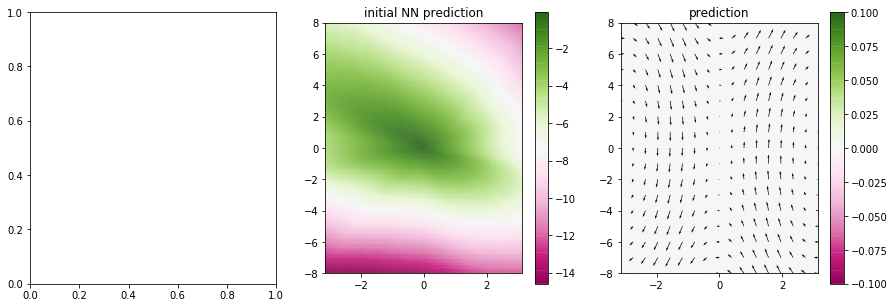

In [52]:
p = Plotter2d(jnn.predict, model, n_grid=100, jupyter=True)
# update_plot(Yhat, loss_list, batch_num)

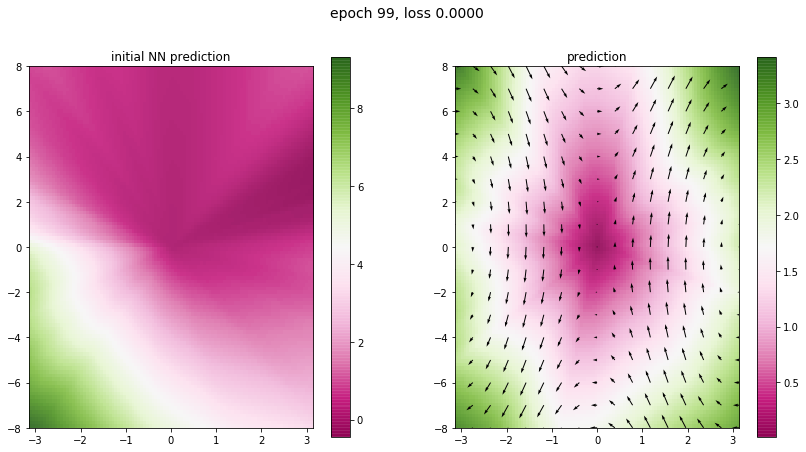

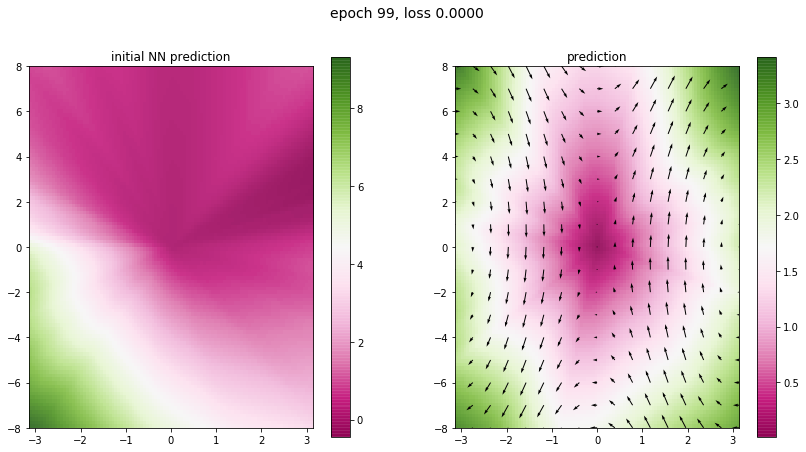

In [127]:
# NOTE in this cell, we estimate the average *reward* at each state, just a proof of concept

T = 300
num_epochs = 100
samples_per_epoch = T*50
batch_size = 100

model = jnn.init_network_params_He([2,80,80,1])

plotter = Plotter2d(jnn.predict, model, n_grid=100, jupyter=True)
stdizer = jnn.RewardStandardizer()

loss_list = []
for i in range(num_epochs):
    epoch_memory = np.zeros((0,3))

    while epoch_memory.shape[0] < samples_per_epoch:
        traj = np.array(PU.pendulumTraj_scan(  
            np.pi * (2*rand() - 1),
            8 * (2*rand() - 0.5),
            np.clip(dampedSpringNoiseJit(T,key=randKey()), -params.max_torque, params.max_torque),
            params
        ))
        traj[:,0] = PU.angle_normalize(traj[:,0])
        epoch_memory = np.vstack([epoch_memory,traj])

    sample_order = np.random.permutation(samples_per_epoch)
    j=0
    while j<samples_per_epoch:
        sample_indices = sample_order[j:j+batch_size]
        j += batch_size
        X = epoch_memory[sample_indices, 0:2].T
        for r in epoch_memory[sample_indices, 2]:
            stdizer.observe_reward(r)
        Y = stdizer.standardize_reward( epoch_memory[sample_indices, 2].T)
        model, loss = jnn.update_and_loss(model,(X,Y),LR=0.00005)
        loss_list.append(loss)
    
    plotter.update_plot(
        jnn.predict(model,plotter.plotX),
        loss_list,
        i
    )   

97 2093 1170 1781 2408 1025  619 2235 1145 2701 1820 1288  814
 1908 2172 1309  431 2646  145  864 1191  442 2888  420  924   16 2240
 2218   79 2420 1289 2940 1534  217 2592   33 2009 1299 2453 1050 1355
  432  682 1785 1944   38 2430 1547  990  936  497 1372  670  258 1236
 1253 1527]
shapes of-- batch (100, 2);   S (2, 100);   S_next (2, 100);   R (1, 100)
learning sample 2000;  loss1 17.70244026184082, loss2 8.750110626220703
[[0.02786447 1.9471381  0.2696016  0.1693252  0.9609367  1.051948
  1.2528222  0.03508756 0.21204321 1.2605989  0.75304747 0.62427145
  0.10802125 1.0318757  0.02873095 0.85450715 0.05604662 0.6771117
  0.8639047  0.5193103  0.7373923  0.51416147 1.1980649  0.77910256
  1.4772065  0.76382494 1.1839324  0.6427887  1.4394395  1.9602307
  0.6486266  1.2725841  1.0690608  0.68775344 0.7517825  0.6485025
  0.21763347 2.0875633  2.0149255  1.4456779  0.99408406 1.9173988
  0.855813   0.880145   1.4676133  0.2454754  0.43220854 0.39433998
  0.01243027 1.520619   1.66

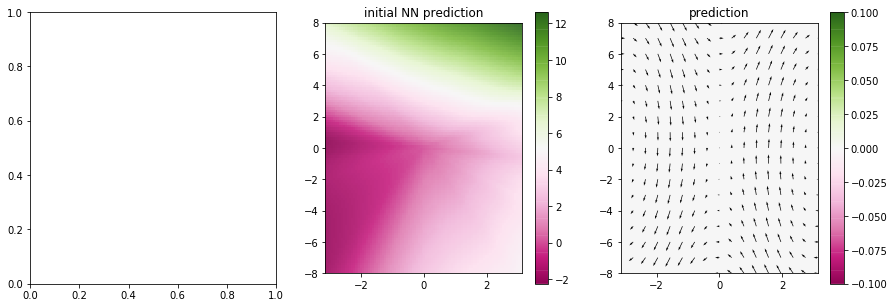

In [76]:
# NOTE now let's try to estimate the VALUE function for an agent using the policy:
# "always take a spring-noise-random action"
# we'll try semi-gradient TD(0), sutton page 203


episode_len = 300
num_epochs = 1
samples_per_epoch = episode_len*10
batch_size = 100

discount = .99

tau=5e-3
LR = 0.00001

vn1 = jnn.init_network_params_He([2,80,80,1])
vn1_targ = jnn.copy_network(vn1)
vn2 = jnn.init_network_params_He([2,80,80,1])
vn2_targ = jnn.copy_network(vn2)

plotter = Plotter2d(jnn.predict, vn1, n_grid=100, jupyter=True)
stdizer = jnn.RewardStandardizer()

loss_list = []
for i in range(num_epochs):
    epoch_memory = np.zeros((0,5))

    e=0
    while epoch_memory.shape[0] < samples_per_epoch:
        # print(f"episode {e} of {samples_per_epoch/episode_len};"
        # f"   {epoch_memory.shape} samples so far", end="\r")
        e+=1
        theta0 = np.pi * (2*rand() - 1)
        thetadot0 = 8 * (2*rand() - 0.5)
        traj = np.array(PU.pendulumTraj_scan(  
            theta0,
            thetadot0,
            np.clip(
                dampedSpringNoiseJit(episode_len,key=randKey()),
                -params.max_torque,
                params.max_torque
            ),
            params
        ))
        traj[:,0] = PU.angle_normalize(traj[:,0])
        # for r in :
        stdizer.observe_reward_vec(traj[:,2])
        R = stdizer.standardize_reward(traj[:-1, 2]).reshape(-1,1)
        S = traj[:-1, 0:2]
        S_next = traj[1:, 0:2]

        episode = np.hstack([S, S_next, R])
        epoch_memory = np.vstack([epoch_memory, episode])

    sample_order = np.random.permutation(samples_per_epoch)
    j=0
    print("sample order", sample_order, "shape", sample_order.shape)
    while j<samples_per_epoch:
        sample_indices = sample_order[j:j+batch_size]
        j += batch_size

        batch = epoch_memory[sample_indices, 0:2]
        
        S = jnp.transpose(epoch_memory[sample_indices, 0:2])
        S_next = jnp.transpose(epoch_memory[sample_indices, 2:4])
        R = jnp.transpose(epoch_memory[sample_indices, 4:5])

        Y = R + discount * np.minimum(
            jnn.predict(vn1_targ, S_next),
            jnn.predict(vn2_targ, S_next)
        )

        # X = S
        # print(f"shape X: {X.shape},   shape Y: {Y.shape}")
        vn1, loss1 = jnn.update_and_loss(vn1, (S,Y), LR)
        loss_list.append(loss1)

        # X = S_next
        # print(f"shape X: {X.shape},   shape Y: {Y.shape}")
        vn2, loss2 = jnn.update_and_loss(vn2, (S_next,Y), LR)

        print(f"episode {e} of {samples_per_epoch/episode_len};"
        f"   {epoch_memory.shape} samples so far"
        f"\n sample indices {sample_indices}")
        print(f"shapes of-- batch {batch.shape};   S {S.shape};   S_next {S_next.shape};   R {R.shape}")
        print(f"learning sample {j};  loss1 {loss1}, loss2 {loss2}")#, end="\r")
        # print("Y", Y)
        print(R)
        # print("vn1", vn1)

    vn1_targ = jnn.interpolate_networks(vn1_targ, vn1, tau)
    vn2_targ = jnn.interpolate_networks(vn2_targ, vn2, tau)
    
    # plotter.update_plot(
    #     jnn.predict(vn1,plotter.plotX),
    #     loss_list,
    #     i
    # )  

In [55]:
loss_list

Array(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dtype=float32),
 DeviceArray(nan, dty

In [20]:
import tree_dynamics_agent as tda
from importlib import reload
reload(tda)

<module 'tree_dynamics_agent' from '/home/bc/projects/deep_rl/jax/tree_dynamics_agent.py'>

In [21]:
tda.Agent(
    state=np.array([[1],[2]]),
    dynamics_layer_sizes=[3,10,2],
    reward_layer_sizes=[3,5,5,1],
    value_layer_sizes=[2,5,1],
    obs_dim=2,
    act_dim=1,
    memory_size=100000,
    batch_size=64,
    target_num_leaves=20
    )

In [ ]:
delta_S

rand_state_0 = (0.0, 0.0, sigma, theta, phi, key)

for i in range(num_episodes):
    state = env.reset()

    value_est = Value(state)

    new_state_node = Node(
        action=None,
        state=state,
        noise_state=rand_state_0,
        value_est=value_est
    )
    T = tree(init_root=new_state_node)

    for t in range(max_timesteps):
        while T.num_leaves() < target_num_leaves:
            state_node = T.softmax_sample_leaf_states()
            state = state_node.state
            noise_state = state_node.noise_state
            noise_state, action = dampedSpringNoiseStep(state.noise_state)
            state_est = state + DynamicsFn.est(state, action)
            reward_est = RewardFn.est(state_est, action)
            value_est = ValueFn.est(state_est)

            new_state_node = Node(
                action=action,
                state=state_est,
                noise_state=noise_state,
                value_est=value_est
            )

            T.add_state(
                parent=state_node,
                child=new_state_node,
                edge_reward=reward_est
            )
        
        target_node = T.softmax_sample_leaf_states()
        next_node = T.step_toward_and_reroot(target_node)
        action = next_node.action
        # NOTE does there need to be a "done" estimator?
        last_state = state
        state, reward, done, _ = env.step(action)
        
        agent.update(last_state, action, reward, state)
        agent.learn()
        DynamicsFn.update(state, last_state, action)
        RewardFn.update(reward, state, action)
        ValueFn.update(reward, state) # ?



